<a href="https://colab.research.google.com/github/josebenitezg/vision-transformer-from-scratch/blob/main/vision_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_vit import ViTForClassfication
%load_ext autoreload
%autoreload 2

In [2]:
#@title Prepare Data 📊
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

In [3]:
# #@title Utils 🛠️
from utils import save_experiment, save_checkpoint, load_experiment, visualize_images, \
                    visualize_attention

In [4]:
#@title Train ViT 🧠 🏋🏽
#@title String fields
from train import Trainer

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 32 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 1e-2  #@param {type: "number"}
save_model_every = 10 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train loss: 1.7621, Test loss: 1.4880, Accuracy: 0.4633
Epoch: 2, Train loss: 1.4160, Test loss: 1.3259, Accuracy: 0.5326
Epoch: 3, Train loss: 1.2601, Test loss: 1.1615, Accuracy: 0.5874
Epoch: 4, Train loss: 1.1639, Test loss: 1.0378, Accuracy: 0.6301
Epoch: 5, Train loss: 1.0939, Test loss: 1.1889, Accuracy: 0.5930
Epoch: 6, Train loss: 1.0477, Test loss: 1.0199, Accuracy: 0.6522
Epoch: 7, Train loss: 0.9985, Test loss: 0.9190, Accuracy: 0.6822
Epoch: 8, Train loss: 0.9795, Test loss: 1.1228, Accuracy: 0.6186
Epoch: 9, Train loss: 0.9564, Test loss: 0.9839, Accuracy: 0.6709
Epoch: 10, Train loss: 0.9697, Test loss: 0.9550, Accuracy: 0.6733
	Save checkpoint at epoch 10
Epoch: 11, Train loss: 0.9277, Test loss: 0.9046, Accuracy: 0.6921
Epoch: 12, Train loss: 0.9069, Test loss: 0.8694, Accuracy: 0.7017
Epoch: 13, Train loss: 0.8984, Test loss: 0.8760, Accuracy: 0.6961
Epoch: 14, Train loss: 0.8752, Te

Files already downloaded and verified


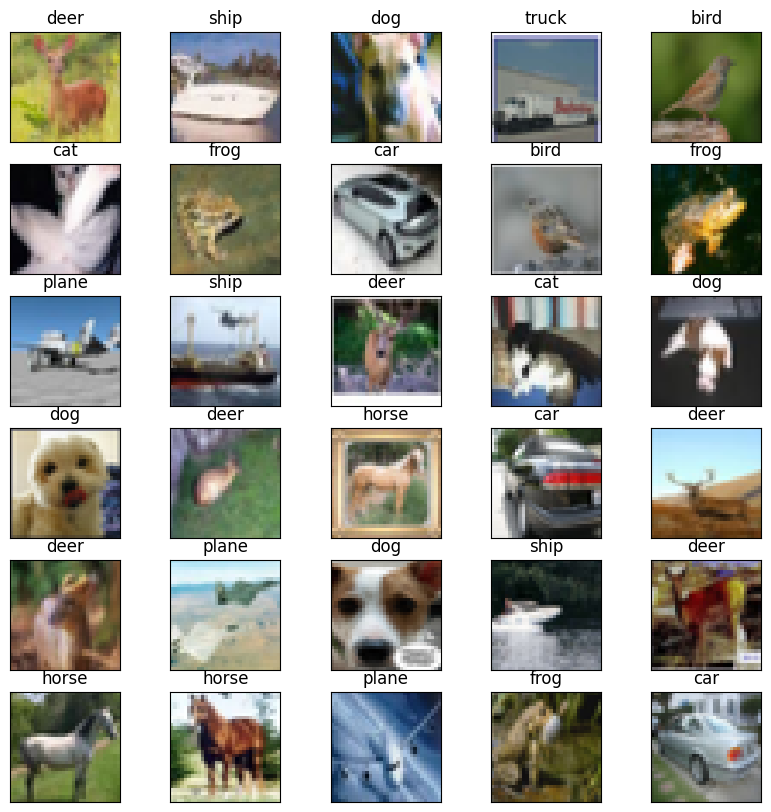

In [5]:
#@title Visualize Dataset
# Show some training images
visualize_images()

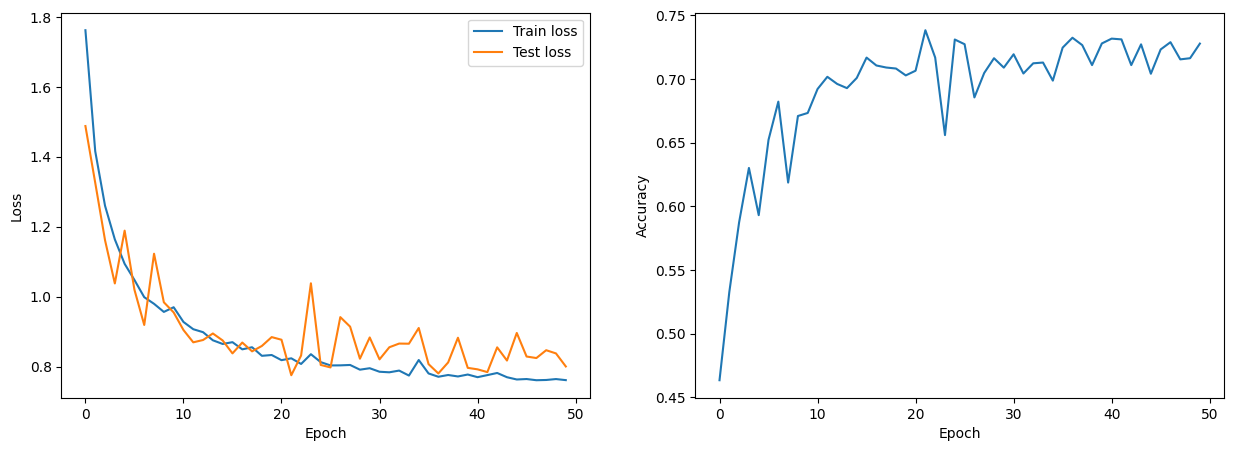

In [6]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

In [7]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

Files already downloaded and verified


/home/bencivjan/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


TypeError: cat() received an invalid combination of arguments - got (NoneType, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)
